In [1]:
n_tr = 40000
n_tst = 10000

myμ = 0.5
myη = 2.0
    
# Preparing the MNIST dataset for training & testing
using MNIST, Images, ImageView;

  likely near /home/parasa/.julia/v0.4/ImageView/src/annotations.jl:43
  likely near /home/parasa/.julia/v0.4/ImageView/src/annotations.jl:43
  likely near /home/parasa/.julia/v0.4/ImageView/src/annotations.jl:61
  likely near /home/parasa/.julia/v0.4/ImageView/src/annotations.jl:61
  likely near /home/parasa/.julia/v0.4/ImageView/src/annotations.jl:61
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:320
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:320
 in require at ./loading.jl:259
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /home/parasa/.julia/v0.4/IJulia/src/execute_request.jl:182
 in eventloop at /home/parasa/.julia/v0.4/IJulia/src/IJulia.jl:142
 in anonymous at task.jl:447
while loading /home/parasa/.julia/v0.4/ImageView/src/annotations.jl, in expression starting on line 96
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./b

In [2]:
# Gets samples from MNIST dataset
function get_from_MNIST(mode, nsamples, view_digits = false)
   
    
    if (mode == "train")
        features = trainfeatures
        labels = trainlabel
         
        X = Matrix{Float64}(nsamples, 784);  # There are 784 features in each of the feature vectors
        Y = Matrix{Float64}(nsamples, 10 );  # One hot coding for each label
    end
    
    if (mode == "test")
        features = testfeatures
        labels = testlabel       
         
        X = Matrix{Float64}(nsamples, 784);  # There are 784 features in each of the feature vectors
        Y = Matrix{Int64}(nsamples, 1);  # No need for one hot coding
    end
    
    
    for i = 1 : nsamples
        X[i, :] = features(i)'
        
        if(view_digits) 
            view(reshape(X[i,:], 28, 28))
        end
        
        label = Int(labels(i))
        
        if(mode == "train")
            onehot = zeros(1, 10)
            onehot[label+1] = 1.0    
            Y[i, :] = onehot        
        end
        
        if(mode == "test")
            Y[i, :] = label      
        end
       
       
    end
    
    return (X/255.0,Y)
end

#@time trX, trY = get_from_MNIST("train", n_tr);
#@time tstX, tstY = get_from_MNIST("test", n_tst);

#data = NN_Data(trX, trY, tstX, tstY);


    

In [3]:
# Need to create a Julia type object for convenience

typealias list Vector{Matrix{Float64}}

sigmoid(z) = 1.0./(1.0 + exp(-z))
tanh_opt(z) = 1.7159 * tanh(2/3.*z)

type NN
    layers
    nlayers
    nwts
    #actiation functions of layers
    f_hidden
    f_output
    W # list of weight matrices
    
    ## The paramets below won't be initialized in the constructor
    
    #training parameters and data structures
    batch_size
    a # list of activations of each layer
    ∂a # derivatives of active functions 
    δ # list of delta matrices
    η # learning rate
    μ # momentum
    ΔW # Weight updates
    ηW # Momentum weights
    err # error at the output layer
    LossFunction # Loss/Cost Function
    
    #Constructor
    function NN(layer_list)
        layers = layer_list
        nlayers = length(layers)
        nwts = nlayers - 1 # number of weight matrices
        W = list(nwts)
        #ΔW = list(nwts)
        #a = list(nlayers) #activations of each layer

        # Initialzie the weight matrices

        for i = 1 : nwts
            rows = layers[i+1] #rows is the #neurons in the next layers
            cols = layers[i] + 1 # cols is the #neurons in the present layer including the bias node
            W[i] = (rand(rows, cols) - 0.5) * 8 * sqrt(6/(rows + cols)) #fancy initialization from DLTB
            #ΔW[i] = zeros(rows, cols)
        end

        #activation functions of hidden and output layers. Input layer has no activation function.
        f_hidden = tanh_opt
        f_output = sigmoid
        
        new(layers, nlayers, nwts, f_hidden, f_output, W)
        
        
    end
    
    
end
    

In [4]:
type Options
    num_epochs
    batch_size
    verbose
    
    function Options(epochs, batchsize)
        new(epochs, batchsize, true)
    end
end

#options = Options(1, 100)

type NN_Data
    #training data
    trainX
    trainY
    #testing data
    testX
    testY
end

@time trX, trY = get_from_MNIST("train", n_tr);
@time tstX, tstY = get_from_MNIST("test", n_tst);

data = NN_Data(trX, trY, tstX, tstY);

    

  5.775383 seconds (5.08 M allocations: 1.231 GB, 3.16% gc time)


  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
  likely near In[4]:155
in x11encode at /home/parasa/.julia/v0.4/Tk/src/widgets.jl
  likely near In[4]:155
in x11encode at /home/parasa/.julia/v0.4/Tk/src/widgets.jl
  likely near In[4]:155
in x11encode at /home/parasa/.julia/v0.4/Tk/src/widgets.jl


  0.803616 seconds (443.19 k allocations: 277.423 MB, 16.12% gc time)


In [5]:
function setup_train_nn(nn::NN, opts::Options)
    nn.batch_size = opts.batch_size
    nn.a = list(nn.nlayers)
    #nn.∂a = list(nn.nlayers)
    nn.δ = list(nn.nlayers)
    nn.ΔW = list(nn.nwts)
    nn.ηW = list(nn.nwts)
    
    nn.μ = 0.5 # momentum
    nn.η = 0.2 # learning rate
    nn.LossFunction = 0.0
    
    for i = 1 : nn.nwts
        nn.ΔW[i] = zeros(size(nn.W[i]))
        nn.ηW[i] = zeros(size(nn.W[i]))
        
        nn.a[i] = zeros(nn.batch_size, nn.layers[i] + 1) #account for bias nodes
        #nn.∂a[i] = zeros(size(nn.a[i]))
        nn.δ[i] = zeros(size(nn.a[i]))
    end

    #for output layer
    n_output = nn.nlayers
    nn.a[n_output] = zeros(nn.batch_size, n_output) # no need for bias node
    #nn.∂a[n_output] = zeros(size(nn.a[n_output]))
    nn.δ[n_output] = zeros(size(nn.a[n_output]))
end

#setup_train_nn(nn, 100)


    
    
    
    

LoadError: LoadError: UndefVarError: nn not defined
while loading In[5], in expression starting on line 31

In [6]:
function feed_forward(nn::NN, batchX, batchY)
    n = nn.nlayers
    m = size(batchX, 1)
    
    x = batchX
    y = batchY
    
    # Add bias terms to the input data and create input layer
    x = [ones(m,1) x]
    nn.a[1] = x
    
    # feed forward pass for hidden layers
    for i = 2 : (n-1)
        nn.a[i] = nn.f_hidden(nn.a[i-1] * nn.W[i-1]')
        # add the bias terms for next layers
        nn.a[i] = [ones(m,1) nn.a[i]]        
    end
    
    #feed forward pass for output layer
    nn.a[n] = nn.f_output(nn.a[n-1] * nn.W[n-1]')
    
    #Calculate error and loss function
    nn.err = y - nn.a[n]
    
    if(nn.f_output == sigmoid)
        nn.LossFunction = 0.5 * sum(sum(nn.err .^2))/m
        #println(nn.LossFunction)
    end
    
end

feed_forward (generic function with 1 method)

In [7]:
function back_prop(nn::NN)
    n = nn.nlayers
    
    #Calculate the output layer δ
    if(nn.f_output == sigmoid)
        nn.δ[n] = -nn.err .* (nn.a[n] .* (1 - nn.a[n]))
    end
    
    #backpropgate to the lower layers
    ∂act = Matrix{Float64}[]
    
    for i = (n-1) : -1 : 2
        
        #derivatives of activation function
        if(nn.f_hidden == sigmoid)
            ∂act = nn.a[i] .* (nn.a[n] .* (1 - nn.a[n]))
        elseif(nn.f_hidden == tanh_opt)
            ∂act = 1.7159 * 2/3 * (1 - 1/(1.7159)^2 * nn.a[i].^2)
        end
        
        # back propagate the derivatives
        
        if (i+1 == n)
            nn.δ[i] = (nn.δ[i+1] * nn.W[i]) .* ∂act
        else
            nn.δ[i] = (nn.δ[i+1][:, 2:end] * nn.W[i]) .* ∂act
        end     
        
    end
    
    for i = 1 : (n-1)
        if(i+1 == n)
            nn.ΔW[i] = (nn.δ[i+1]' * nn.a[i])/size(nn.δ[i+1], 1)
        else
            nn.ΔW[i] = (nn.δ[i+1][:, 2:end]' * nn.a[i])/size(nn.δ[i+1], 1)
        end
    end
      
end


back_prop (generic function with 1 method)

In [8]:
function apply_gradients(nn::NN)
    
    dW = Matrix{Float64}[]
    
    for i = 1 : nn.nwts
        dW = nn.η * nn.ΔW[i]
        
        if(nn.η > 0.0)
            nn.ηW[i] = nn.η * nn.ηW[i] + dW
            dW = nn.ηW[i]
        end
        
        nn.W[i] -= dW
    end
end


apply_gradients (generic function with 1 method)

In [9]:
function trainNN(nn::NN, opts::Options, data::NN_Data)
    
    # Number of training samples
    m = size(data.trainX, 1) 
    batch_size = opts.batch_size
    num_epochs = opts.num_epochs
    num_batches = Int(m/batch_size)
    
    Loss = zeros(num_epochs * num_batches, 1)
    cnt = 1
    
    #Setups the datastructures for the traning the NN
    setup_train_nn(nn, opts)
    
    for i = 1 : num_epochs
        tic()
        
        #Create a random permutation of the training dataset for each epoch
        rp = randperm(m)
        
        for j = 1 : num_batches
            
            batch_start = (j-1) * batch_size + 1
            batch_end = batch_start + batch_size - 1            
            batch_indices = rp[batch_start : batch_end]
            
            batchX = data.trainX[batch_indices, :]
            batchY = data.trainY[batch_indices, :]
            
            feed_forward(nn, batchX, batchY)
            back_prop(nn)
            apply_gradients(nn)
            Loss[cnt] = nn.LossFunction
            cnt = cnt + 1
            
            
        end
        
        toc()
        
    end
    
    return Loss

end



trainNN (generic function with 1 method)

In [10]:
nn = NN([784 100 10])
nn.μ = myμ
nn.η = myη
opts = Options(1, 100)
#setup_train_nn(nn, opts)
loss = trainNN(nn, opts, data)


elapsed time: 3.651900101 seconds


400x1 Array{Float64,2}:
 2.38695 
 1.62639 
 0.981767
 0.688936
 0.579015
 0.53477 
 0.527506
 0.530504
 0.49511 
 0.488846
 0.50099 
 0.487857
 0.448156
 ⋮       
 0.189249
 0.237846
 0.195543
 0.187023
 0.175999
 0.19559 
 0.177906
 0.183817
 0.223512
 0.218507
 0.182072
 0.163328

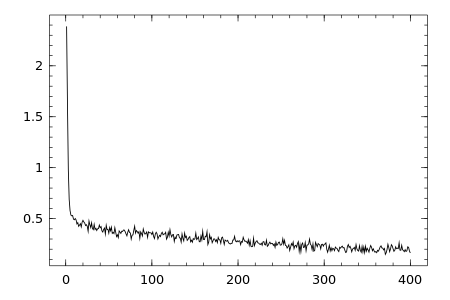

In [11]:
using Winston
plot(loss)

In [12]:
function feed_forward_test(nn::NN, testX)
    n = nn.nlayers
    m = size(testX, 1)
    
    x = testX
       
    # Add bias terms to the input data and create input layer
    x = [ones(m,1) x]
    nn.a[1] = x
    
    # feed forward pass for hidden layers
    for i = 2 : (n-1)
        nn.a[i] = nn.f_hidden(nn.a[i-1] * nn.W[i-1]')
        # add the bias terms for next layers
        nn.a[i] = [ones(m,1) nn.a[i]]        
    end
    
    #feed forward pass for output layer
    nn.a[n] = nn.f_output(nn.a[n-1] * nn.W[n-1]')
  
end



feed_forward_test (generic function with 1 method)

In [13]:
function nntest(nn::NN, testX, testY)
    feed_forward_test(nn, testX)
    output = nn.a[end]
    m = size(output, 1)
    predicted_labels = Vector{Int64}(m)
    
    for i = 1 : m
        mx = maximum(output[i,:])
        idx = find(output[i,:] .== mx)
        predicted_labels[i] = idx[1] - 1
    end
    
    accuracy = sum(predicted_labels .== testY)/m
    return accuracy
end


nntest (generic function with 1 method)

In [14]:
#feed_forward_test(nn, data.testX)
efficieny = nntest(nn, data.testX, data.testY)


0.7241